In [2]:
# STEP 1: Load Data
import pandas as pd
from cassandra.cluster import Cluster

def load_data(symbol):
    cluster = Cluster(['127.0.0.1'])
    session = cluster.connect('stock_data')

    query = f"""
    SELECT symbol, date, open, high, low, close, volume
    FROM candlestick_data
    WHERE symbol = '{symbol}'
    ALLOW FILTERING
    """

    df = pd.DataFrame(list(session.execute(query)))
    return df

df = load_data("BANPU")
df.head()


,symbol,date,open,high,low,close,volume
0,BANPU,2022-12-27,13.5,13.5,13.4,13.4,39796280
1,BANPU,2022-12-28,13.5,13.7,13.4,13.7,58996837
2,BANPU,2022-12-29,13.6,13.7,13.5,13.7,57984971
3,BANPU,2022-12-30,13.7,13.8,13.6,13.7,49373887
4,BANPU,2023-01-03,13.7,13.7,13.4,13.4,104091420


In [5]:
# STEP 2: Clean Data
import pandas as pd

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df = df.dropna()


In [7]:
# STEP 3: Feature Engineering
import pandas_ta as ta

df['rsi'] = ta.rsi(df['close'], length=14)
df.ta.macd(fast=12, slow=26, signal=9, append=True)

df = df.dropna().reset_index(drop=True)
df.head()


,symbol,date,open,high,low,close,volume,rsi,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,BANPU,2023-03-31,10.9,10.9,10.7,10.8,38401248,49.633779,-0.064804,0.077021,-0.141824
1,BANPU,2023-04-03,10.9,11.1,10.9,11.1,84758919,56.606229,-0.035368,0.085165,-0.120533
2,BANPU,2023-04-04,11.1,11.1,10.9,11.0,72137310,53.926370,-0.019879,0.080523,-0.100402
3,BANPU,2023-04-05,11.0,11.1,10.8,10.8,86207209,48.936457,-0.023473,0.061544,-0.085016
4,BANPU,2023-04-07,10.9,11.0,10.8,10.9,128497345,51.359932,-0.018043,0.053579,-0.071622


In [8]:
# STEP 4: Labeling
import numpy as np
from scipy.signal import find_peaks

def label_head_shoulders(prices, distance=15, tolerance=0.05):
    labels = np.zeros(len(prices))
    peaks, _ = find_peaks(prices, distance=distance)

    for i in range(1, len(peaks) - 1):
        l, h, r = peaks[i-1], peaks[i], peaks[i+1]

        left, head, right = prices[l], prices[h], prices[r]

        if head > left and head > right:
            if abs(left - right) / head < tolerance:
                labels[h] = 1

    return labels

df['label'] = label_head_shoulders(df['close'].values)
print("Total H&S labels:", df['label'].sum())


Total H&S labels: 2.0


In [9]:
# STEP 5: Split by Time
split_ratio = 0.8
split_idx = int(len(df) * split_ratio)

train_df = df.iloc[:split_idx]
test_df  = df.iloc[split_idx:]


In [12]:
# STEP 6: Scaling
from sklearn.preprocessing import MinMaxScaler

feature_cols = [
    'open', 'high', 'low', 'close',
    'volume', 'rsi', 'MACD_12_26_9', 'MACDs_12_26_9'
]

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[feature_cols])
test_scaled  = scaler.transform(test_df[feature_cols])


In [13]:
# STEP 7: Window Dataset
import numpy as np

WINDOW_SIZE = 60

def create_dataset(data, labels, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(labels[i+window])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(
    train_scaled,
    train_df['label'].values,
    WINDOW_SIZE
)

X_test, y_test = create_dataset(
    test_scaled,
    test_df['label'].values,
    WINDOW_SIZE
)


In [14]:
# STEP 8: Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

model = Sequential([
    Conv1D(64, 3, activation='relu',
           input_shape=(WINDOW_SIZE, len(feature_cols))),
    MaxPooling1D(2),
    LSTM(50),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,651 (96.29 KB)

 Trainable params: 24,651 (96.29 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# STEP 9: Training
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9894 - loss: 0.3653 - val_accuracy: 0.9895 - val_loss: 0.2158
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9973 - loss: 0.0467 - val_accuracy: 0.9895 - val_loss: 0.0581
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9973 - loss: 0.0209 - val_accuracy: 0.9895 - val_loss: 0.0636
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9973 - loss: 0.0207 - val_accuracy: 0.9895 - val_loss: 0.0665
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9973 - loss: 0.0205 - val_accuracy: 0.9895 - val_loss: 0.0667
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9973 - loss: 0.0182 - val_accuracy: 0.9895 - val_loss: 0.0669
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9973 - loss: 0.0200 - val_accuracy: 0.9895 - val_loss: 0.0668
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9973 - loss: 0.0196 - val_accuracy: 0.9895 - val_lo

In [16]:
# STEP 10: Evaluation
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[73]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        73

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73



/Users/hilmanyusoh/Desktop/Stock-market-chart-pattern-recognition-using-deep-learning/stock_pattern/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:620: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


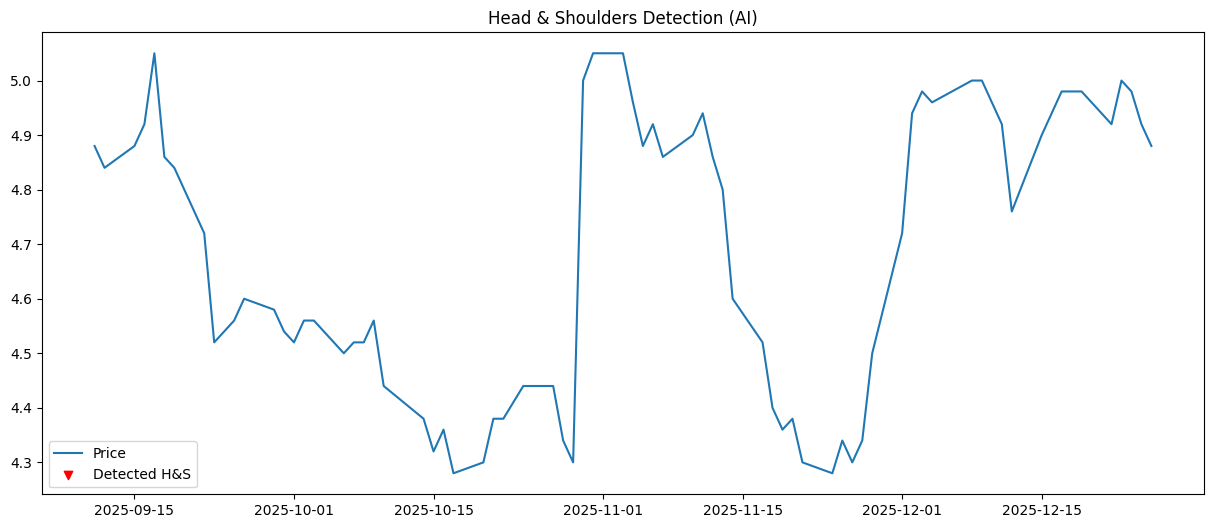

In [17]:
# STEP 11: Visual Check
import matplotlib.pyplot as plt
import numpy as np

pred_probs = model.predict(X_test)

dates = test_df['date'].iloc[WINDOW_SIZE:].values
prices = test_df['close'].iloc[WINDOW_SIZE:].values

plt.figure(figsize=(15,6))
plt.plot(dates, prices, label='Price')

detected = np.where(pred_probs.flatten() > 0.7)[0]
plt.scatter(dates[detected], prices[detected],
            color='red', marker='v', label='Detected H&S')

plt.legend()
plt.title("Head & Shoulders Detection (AI)")
plt.show()
